In [25]:
import wandb
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import h5py
# Import TCN
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.append(project_root)
mldriven_peled_dir = os.path.join(project_root, "mldrivenpeled")
if mldriven_peled_dir not in sys.path:
    sys.path.append(mldriven_peled_dir)
from lab_scripts.encoder_decoder import TCN
from lab_scripts.constellation_diagram import QPSK_Constellation
from lab_scripts.constellation_diagram import RingShapedConstellation
if wandb.run is not None:
    wandb.run.tags = list(wandb.run.tags) + ['junk']
    wandb.finish()

In [26]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps") # for M chip Macs
else:
    device = torch.device("cpu")
print(device)

mps


In [27]:
import torch.nn as nn

class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            dilation=dilation,
            padding=(kernel_size - 1) * dilation
        )
        self.relu = nn.ReLU()
        self.resample = None
        if in_channels != out_channels:
            self.resample = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.conv(x)
        out = self.relu(out)
        if out.size(2) > x.size(2):
            out = out[:, :, :x.size(2)]
        if self.resample:
            x = self.resample(x)
        return out + x  # residual connection


class TCN(nn.Module):
    def __init__(self, nlayers=3, dilation_base=2, num_taps=10, hidden_channels=32):
        super().__init__()
        layers = []
        in_channels = 1
        for i in range(nlayers):
            dilation = dilation_base ** i
            layers.append(
                TCNBlock(in_channels, hidden_channels, num_taps, dilation)
            )
            in_channels = hidden_channels
        self.tcn = nn.Sequential(*layers)
        self.readout = nn.Conv1d(hidden_channels, 1, kernel_size=1)

    def forward(self, xin):
        x = xin.unsqueeze(1)    # [B,1,T]
        out = self.tcn(x)     # [B,H,T]
        out = self.readout(out).squeeze(1)
        out = out - out.mean(dim=1, keepdim=True)  # [B,T]
        return out


class TCN_channel(nn.Module):
    def __init__(self, nlayers=3, dilation_base=2, num_taps=10, hidden_channels=32, learn_noise=False):
        super().__init__()
        layers = []
        in_channels = 1
        for i in range(nlayers):
            dilation = dilation_base ** i
            layers.append(
                TCNBlock(in_channels, hidden_channels, num_taps, dilation)
            )
            in_channels = hidden_channels
        self.learn_noise = learn_noise
        self.tcn = nn.Sequential(*layers)
        self.readout = nn.Conv1d(hidden_channels, 2, kernel_size=1) # 2 channels mean | std

    def forward(self, xin):
        x = xin.unsqueeze(1)    # [B,1,T]
        out = self.tcn(x)     # [B,H,T]
        out = self.readout(out) # [B, 2, T] mean | std
        mean_out = out[:, 0, :]
        log_std_out = out[:, 1, :]
        std_out = torch.exp(log_std_out)
        mean_out = mean_out - mean_out.mean(dim=1, keepdim=True)  # [B ,T]


        # # Produce noise output
        noisy_out = mean_out + std_out * torch.randn_like(mean_out)
        if self.learn_noise:
            return noisy_out, mean_out, std_out
        else:
            return mean_out, mean_out, 0

In [28]:
# Channel Model
api = wandb.Api()
run = api.run("dylanbackprops-university-of-washington/mldrivenpeled/z3j8evkc") # Variable
model_name = "channel_model_final"
artifact = api.artifact("dylanbackprops-university-of-washington/mldrivenpeled/channel_model:v250") # Variable
channel_artifact_dir = artifact.download()
channel_config = run.config
run_name = run.name
print("Channel Run name:", run_name)


wandb:   1 of 1 files downloaded.  


Channel Run name: frosty-star-4485


In [ ]:
channel_model = TCN_channel(
    nlayers=channel_config['nlayers'],
    dilation_base=channel_config['dilation_base'],
    num_taps=channel_config['num_taps'],
    hidden_channels=channel_config['hidden_channels'],
    learn_noise=channel_config['learn_noise']
).to(device)


channel_model_path = os.path.join(channel_artifact_dir, model_name + ".pth")
checkpoint = torch.load(channel_model_path)
channel_model.load_state_dict(checkpoint["channel_model"])

for param in channel_model.parameters():
    param.requires_grad = False

channel_model = channel_model.to(device)
channel_model.eval()

def count_params(model):
    return sum(p.numel() for p in model.parameters())

print(f"Channel model params: {count_params(channel_model):,}")

Channel model params: 346


/var/folders/xs/qxccznl53g76p79cp1cpszh40000gn/T/ipykernel_98925/1178802006.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(channel_model_path)


In [30]:
constellation_mode = "m7_apsk_constellation"

def get_constellation(mode: str):
        if mode == "qpsk":
            constellation = QPSK_Constellation()
        elif mode == "m5_apsk_constellation":
            constellation = RingShapedConstellation(filename=r'/Users/dylanjones/Desktop/mldrivenpeled/lab_scripts/saved_constellations/m5_apsk_constellation.npy')
        elif mode == "m6_apsk_constellation":
             constellation = RingShapedConstellation(filename=r'/Users/dylanjones/Desktop/mldrivenpeled/lab_scripts/saved_constellations/m6_apsk_constellation.npy')
        elif mode == "m7_apsk_constellation":
             constellation = RingShapedConstellation(filename=r'/Users/dylanjones/Desktop/mldrivenpeled/lab_scripts/saved_constellations/m7_apsk_constellation.npy')
        return constellation

constellation = get_constellation(constellation_mode)

In [31]:
def evm_loss(true_symbols, predicted_symbols):
    return torch.mean(torch.abs(true_symbols - predicted_symbols) ** 2)

def symbols_to_time(X, num_padding_zeros: int, num_leading_zeros=0):
    # Make hermetian symmetric
    Nt, Nf = X.shape
    padding_zeros = torch.zeros(Nt, num_padding_zeros, device=device)
    leading_zeros = torch.zeros(Nt, num_leading_zeros, device=device)
    X = torch.cat([leading_zeros, X.to(device), padding_zeros], dim=-1)
    DC_Nyquist = torch.zeros((X.shape[0], 1), device=X.device)
    X_hermitian = torch.flip(X, dims=[1]).conj()
    X_full = torch.hstack([DC_Nyquist, X, DC_Nyquist, X_hermitian])
    # Convert to time domain
    x_time = torch.fft.ifft(X_full, dim=-1, norm="ortho").real
    return x_time.to(device)

In [32]:
channel_config

{'Nf': 370,
 'Nt': 1,
 'lr': 0.009,
 'flow': 10000,
 'gain': 20,
 'fhigh': '6e6',
 'epochs': 20,
 'nlayers': 2,
 'CP_ratio': 0.25,
 'num_taps': 16,
 'dc_offset': 3.5,
 'batch_size': 64,
 'learn_noise': True,
 'weight_init': 'default',
 'dilation_base': 2,
 'scheduler_type': 'reduce_lr_on_plateu',
 'hidden_channels': 4,
 'num_points_symbol': 2029,
 'subcarrier_spacing': '1e4',
 'num_symbols_per_frame': 1}

In [ ]:
# Characterize system by scaling SNR
NUM_POINTS_FRAME = 1522
CP_LENGTH = 507
PREAMBLE_MAX = 3

NUM_BITS = channel_config['Nt'] * channel_config['Nf'] * constellation.modulation_order

FREQUENCIES = torch.arange(float(channel_config['flow']), float(channel_config['fhigh']), float(channel_config['subcarrier_spacing']))
delta_f = FREQUENCIES[1] - FREQUENCIES[0]
KS = (FREQUENCIES / delta_f).to(torch.int)
K_MIN = int(KS[0].item())
K_MAX = int(KS[-1].item())
NUM_ZEROS = K_MIN - 1
UPSAMPLING_ZEROS= (NUM_POINTS_FRAME + -2 * K_MIN + -2 * len(KS)) // 2
UPSAMPLING_ZEROS

161

In [44]:
def add_noise(signal, SNR):
    signal_power = signal.abs().pow(2).mean()
    noise_power = signal_power / SNR
    noise_std = (noise_power / 2) ** 0.5 # real and complex
    noise = noise_std * torch.randn_like(signal) + noise_std * 1j * torch.randn_like(signal)
    signal += noise
    return signal

def evm_loss(true_symbols, predicted_symbols):
    return torch.mean(torch.abs(true_symbols - predicted_symbols) ** 2)

In [45]:
NUM_BITS

4193

In [46]:
NUM_ITERS = 100
BATCH_SIZE = 512
SNR_MIN = 10
SNR_MAX = 1e4
SNRS = torch.linspace(SNR_MIN, SNR_MAX, NUM_ITERS)
residuals = []
for i in range(NUM_ITERS):
    # Generate input
    true_bits = np.random.randint(0, 2, size=NUM_BITS * BATCH_SIZE)
    true_bits_str = ''.join(map(str, true_bits))
    true_symbols = torch.tensor(
                constellation.bits_to_symbols(true_bits_str),
                dtype=torch.complex64, device=device
    )
    true_frame = true_symbols.reshape(BATCH_SIZE, channel_config["Nf"])

    # Add noise for target SNR
    true_frame_noisy = add_noise(true_frame, SNRS[i])

    # convert to time
    true_frame_time = symbols_to_time(true_frame, UPSAMPLING_ZEROS, NUM_ZEROS)
    true_frame_time_noisy = symbols_to_time(true_frame_noisy, UPSAMPLING_ZEROS, NUM_ZEROS)

    true_frame_time = torch.hstack((true_frame_time[:, -CP_LENGTH:], true_frame_time))
    true_frame_time_noisy = torch.hstack((true_frame_time_noisy[:, -CP_LENGTH:], true_frame_time_noisy))

    received_frame_time, _, _ = channel_model(true_frame_time)
    received_frame_time_noisy, _, _ = channel_model(true_frame_time_noisy)

    # Convert back to frequency
    received_frame = torch.fft.fft(received_frame_time[:, CP_LENGTH:], dim=1, norm="ortho")[:, KS]
    received_frame_noisy = torch.fft.fft(received_frame_time_noisy[:, CP_LENGTH:], dim=1, norm="ortho")[:, KS]

    residuals.append(received_frame_noisy - true_frame)

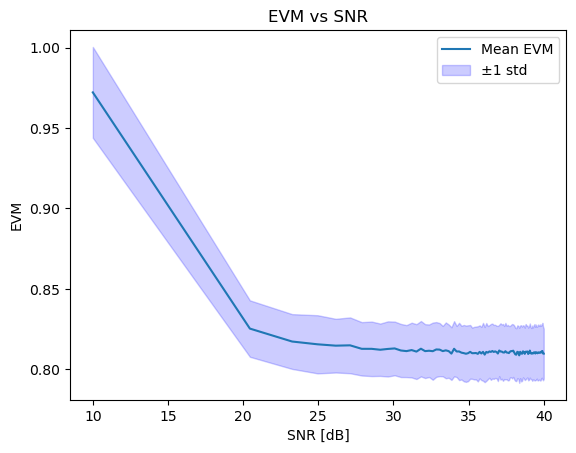

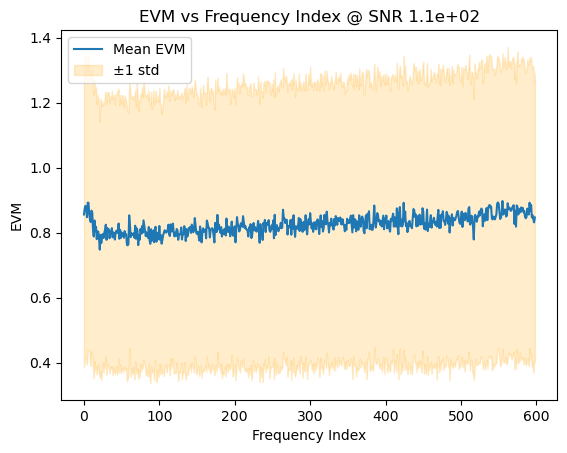

In [47]:
SNR_IDX = 1

snrs_db = 10 * torch.log10(SNRS)
snr_at_idx = SNRS[SNR_IDX]
residuals_tensor = torch.stack(residuals)           # [NUM_ITERS, BATCH_SIZE, Nf]
evm_all = residuals_tensor.abs().pow(2).mean(-1)    # [NUM_ITERS, BATCH_SIZE]
evm_mean = evm_all.mean(1)                          # [NUM_ITERS]
evm_std  = evm_all.std(1)                           # [NUM_ITERS]

plt.figure()
plt.plot(snrs_db.cpu(), evm_mean.cpu(), label="Mean EVM")
plt.fill_between(snrs_db.cpu(),
                 (evm_mean - evm_std).cpu(),
                 (evm_mean + evm_std).cpu(),
                 color="blue", alpha=0.2, label="±1 std")
plt.xlabel("SNR [dB]")
plt.ylabel("EVM")
plt.title("EVM vs SNR")
plt.legend()

# For that SNR, look across the batch
evm_per_freq = residuals_tensor[SNR_IDX].abs().pow(2)   # [BATCH_SIZE, Nf]
freq_mean = evm_per_freq.mean(0)                       # [Nf]
freq_std  = evm_per_freq.std(0)                        # [Nf]

plt.figure()
plt.plot(freq_mean.cpu(), label="Mean EVM")
plt.fill_between(torch.arange(freq_mean.numel()),
                 (freq_mean - freq_std).cpu(),
                 (freq_mean + freq_std).cpu(),
                 color="orange", alpha=0.2, label="±1 std")
plt.xlabel("Frequency Index")
plt.ylabel("EVM")
plt.title(f"EVM vs Frequency Index @ SNR {snr_at_idx:.1e}")
plt.legend()

plt.show()


In [48]:
# Check experimental results
file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/characterize_channel_3.5V.h5"
DTYPE = torch.complex64
sent = []
received = []
received_time = []
snr_indx = []
FREQUENCIES = None
with h5py.File(file_path, "r") as f:
    # Get frequency
    first_frame = list(f.keys())[0]
    FREQUENCIES = torch.tensor(f[first_frame]['freqs'][:], dtype=DTYPE).to(device).real
    NUM_POINTS_SYMBOL = int(f[first_frame]['num_points_symbol'][()])
    CP_LENGTH = int(f[first_frame]['cp_length'][()])
    for frame in f:
        group = f[frame]
        sent.append(torch.tensor(group['sent'][:], dtype=DTYPE))
        received.append(torch.tensor(group['received'][:], dtype=DTYPE))
        received_time.append(torch.tensor(group['received_time'][:], dtype=DTYPE))
        snr_indx.append(torch.tensor(group.attrs['snr_idx'], dtype=torch.int64))

In [49]:
sent_frames_exp = torch.stack(sent).squeeze(1)
received_frames_exp = torch.stack(received).squeeze(1)[:, KS] # Select in-band
snr_indices = torch.stack(snr_indx)

In [50]:
sent_frames_exp.shape, received_frames_exp.shape, snr_indices.shape

(torch.Size([6133, 370]), torch.Size([6133, 599]), torch.Size([6133]))

In [51]:
snrs_db = 10 * torch.log10(SNRS)
residual_tensor_exp = (sent_frames_exp - received_frames_exp)

batched_SNR_tensor = []
unique_snr_idxs = snr_indices.unique()

evm_mean_exp = []
evm_std_exp = []

for idx in unique_snr_idxs:
    mask = snr_indices == idx
    evm_idx = residual_tensor_exp[mask].abs().pow(2).mean(-1)
    evm_mean_exp.append(evm_idx.mean())
    evm_std_exp.append(evm_idx.std())


evm_mean_exp = torch.stack(evm_mean_exp)
evm_std_exp = torch.stack(evm_std_exp)

snr_at_idx = SNRS[SNR_IDX]

plt.figure()
plt.plot(snrs_db.cpu(), evm_mean_exp.cpu(), label="Mean EVM Exp")
plt.fill_between(snrs_db.cpu(),
                 (evm_mean_exp - evm_std_exp).cpu(),
                 (evm_mean_exp + evm_std_exp).cpu(),
                 color="blue", alpha=0.2, label="±1 std")
plt.xlabel("SNR [dB]")
plt.ylabel("EVM")
plt.title("EVM vs SNR")
plt.legend()

# For that SNR, look across the batch

mask = snr_indices == SNR_IDX
evms_at_snr = residual_tensor_exp[mask].abs().pow(2)
freq_mean_exp = evms_at_snr.mean(0)                       # [Nf]
freq_std_ex  = evms_at_snr.std(0)                        # [Nf]


plt.figure()
plt.plot(freq_mean_exp.cpu(), label="Mean EVM Exp")
plt.fill_between(torch.arange(freq_mean_exp.numel()),
                 (freq_mean_exp - freq_std_ex).cpu(),
                 (freq_mean_exp + freq_std_ex).cpu(),
                 color="orange", alpha=0.2, label="±1 std")
plt.xlabel("Frequency Index")
plt.ylabel("EVM")
plt.title(f"EVM vs Frequency Index @ SNR {snr_at_idx:.1e}")
plt.legend()

plt.show()


RuntimeError: The size of tensor a (370) must match the size of tensor b (599) at non-singleton dimension 1

/var/folders/xs/qxccznl53g76p79cp1cpszh40000gn/T/ipykernel_98925/3498568109.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


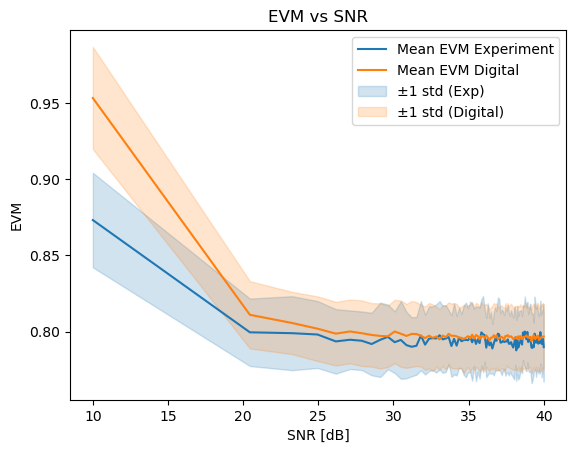

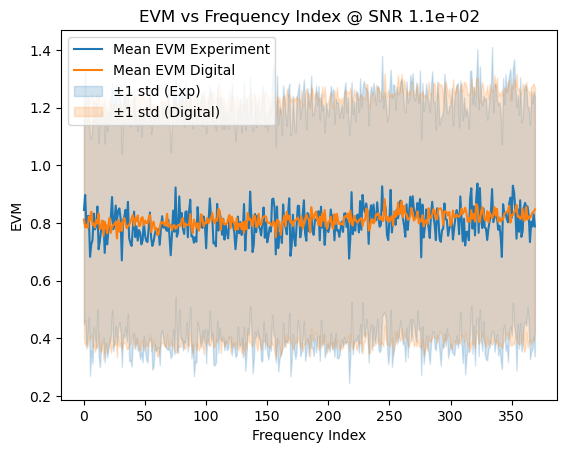

In [ ]:
import matplotlib.cm as cm

cmap = cm.get_cmap("tab10")
exp_color = cmap(0)   # blue
dig_color = cmap(1)   # orange

plt.figure()
plt.plot(snrs_db.cpu(), evm_mean_exp.cpu(), label="Mean EVM Experiment", color=exp_color)
plt.plot(snrs_db.cpu(), evm_mean.cpu(), label="Mean EVM Digital", color=dig_color)

plt.fill_between(snrs_db.cpu(),
                 (evm_mean_exp - evm_std_exp).cpu(),
                 (evm_mean_exp + evm_std_exp).cpu(),
                 color=exp_color, alpha=0.2, label="±1 std (Exp)")
plt.fill_between(snrs_db.cpu(),
                 (evm_mean - evm_std).cpu(),
                 (evm_mean + evm_std).cpu(),
                 color=dig_color, alpha=0.2, label="±1 std (Digital)")

plt.xlabel("SNR [dB]")
plt.ylabel("EVM")
plt.title("EVM vs SNR")
plt.legend()

plt.figure()
plt.plot(freq_mean_exp.cpu(), label="Mean EVM Experiment", color=exp_color)
plt.plot(freq_mean.cpu(), label="Mean EVM Digital", color=dig_color)

plt.fill_between(torch.arange(freq_mean_exp.numel()),
                 (freq_mean_exp - freq_std_ex).cpu(),
                 (freq_mean_exp + freq_std_ex).cpu(),
                 color=exp_color, alpha=0.2, label="±1 std (Exp)")
plt.fill_between(torch.arange(freq_mean.numel()),
                 (freq_mean - freq_std).cpu(),
                 (freq_mean + freq_std).cpu(),
                 color=dig_color, alpha=0.2, label="±1 std (Digital)")

plt.xlabel("Frequency Index")
plt.ylabel("EVM")
plt.title(f"EVM vs Frequency Index @ SNR {snr_at_idx:.1e}")
plt.legend()

plt.show()
